In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal
import os
import inspect

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import Spectrogram
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

In [4]:
fft_size = 1024

In [5]:
from pyha.cores import BitreversalFFTshiftAVGPool
file = os.path.dirname(inspect.getfile(BitreversalFFTshiftAVGPool)) + '/phantom3_low_power_bladerf.npy'
orig_inp = np.load(file) # IQ samples
orig_inp = orig_inp[:int(len(orig_inp)/fft_size)*fft_size]
print(len(orig_inp))
# orig_inp *= 128

139264


## Spectrogram

In [6]:
dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=2)
sims = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139265/139265 [02:41<00:00, 859.94it/s]

INFO:sim:Flushing the pipeline...


INFO:sim:OK!
INFO:sim:Simulations completed!


SNR: 19.15
(8704,)


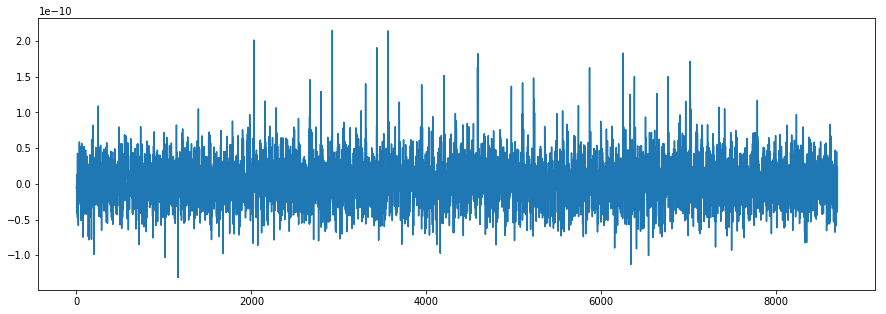

In [7]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
plt.plot(sims['MODEL'] - sims['PYHA'])
print(sims['MODEL'].shape)

SNR: 19.15


TypeError: Invalid dimensions for image data

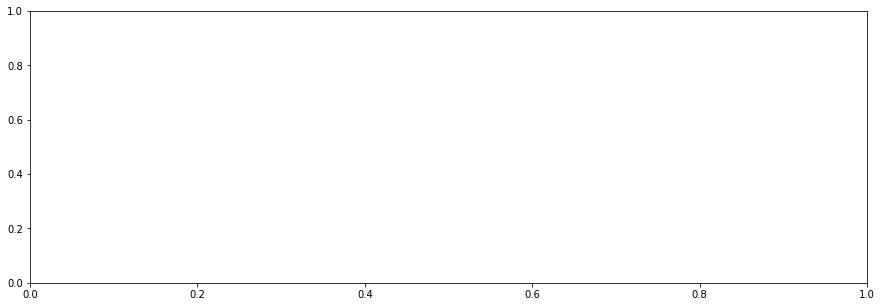

In [8]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
imshow(sims['PYHA'].T)

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

## Average pooling cannot be turned off i.e. setting `avg_freq_axis=1, avg_time_axis=1`
For this case the implementation could be simplified i.e. no need for high-precision fixed-point and read-modify-write.

# Synthesis
`avg_freq_axis` controls the memory usage and decimates the output data rate.

`avg_time_axis` decimates output data rate but has ~no effect on resource usage.

## `avg_freq_axis=8` and `avg_time_axis=4`

In [21]:
conv_dir = '~/Documents/pyha_output'
fft_size = 1024 * 8
dut = Spectrogram(fft_size, avg_freq_axis=16, avg_time_axis=1, fft_twiddle_bits=9, window_bits=8)
sims = simulate(dut, orig_inp[:2*fft_size], simulations=['PYHA', 'GATE'], conversion_path=conv_dir)

INFO:sim:Running "PYHA" simulation...


100%|██████████| 16385/16385 [01:31<00:00, 179.56it/s]

INFO:sim:Flushing the pipeline...


INFO:sim:Flushing took 8752 cycles
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DataValidPackager to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:conversion:WrappingCounter to VHDL ...
INFO:conversion:Windower to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SD

KeyboardInterrupt: 

In [ ]:
# 1024 dut = Spectrogram(fft_size, avg_freq_axis=16, avg_time_axis=1, fft_twiddle_bits=9, window_bits=8)
# INFO:sim:Total logic elements : 5,117
# INFO:sim:    Total combinational functions : 4,820
# INFO:sim:    Dedicated logic registers : 2,514
# INFO:sim:Total registers : 2514
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 59,004
# INFO:sim:Embedded Multiplier 9-bit elements : 80

# dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=1, fft_twiddle_bits=9, window_bits=8)
# INFO:sim:Family : Cyclone IV E
# INFO:sim:Total logic elements : 5,125
# INFO:sim:    Total combinational functions : 4,829
# INFO:sim:    Dedicated logic registers : 2,519
# INFO:sim:Total registers : 2519
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 63,612
# INFO:sim:Embedded Multiplier 9-bit elements : 80

In [19]:
((1024*8) * (18 * 2))

294912

In [ ]:
# INFO:sim:Family : Cyclone IV E
# INFO:sim:Total logic elements : 10,821
# INFO:sim:    Total combinational functions : 10,527
# INFO:sim:    Dedicated logic registers : 3,171
# INFO:sim:Total registers : 3171
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 607,140
# INFO:sim:Embedded Multiplier 9-bit elements : 104

In [ ]:
assert sims_close(sims, rtol=1e-10, atol=1e-10)

In [ ]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')